In [1]:
import cv2
import mobiofp
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = "../data"
IMAGES_PATH = [
    DATA_DIR + '/processed/44_i_1_w_7_fingerprint.png', # Gallery
    DATA_DIR + '/processed/53_o_2_n_2_fingerprint.png', # Probe
]

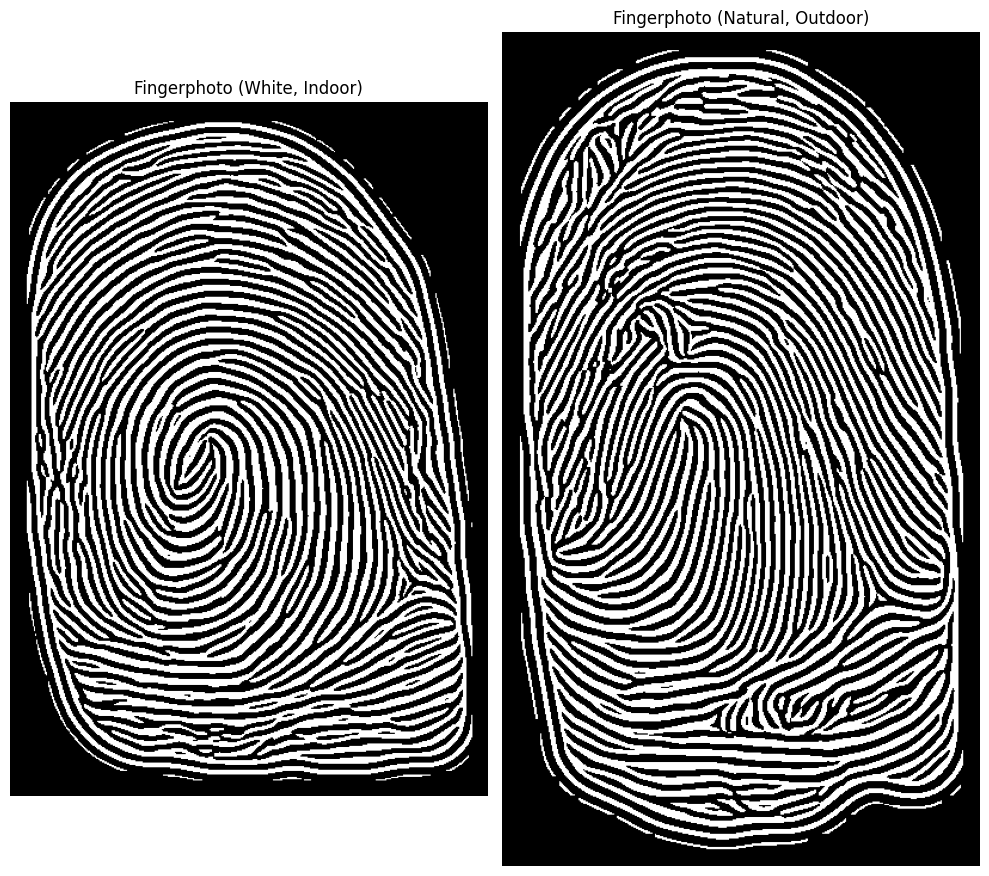

In [3]:
images = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in IMAGES_PATH]

mobiofp.plot_images(images, ['Fingerphoto (White, Indoor)', 'Fingerphoto (Natural, Outdoor)'], 1, 2)

## Feature Representation using [Fingerprint-Enhancement-Python](https://github.com/Utkarsh-Deshmukh/Fingerprint-Enhancement-Python)

In [4]:
terminations_wi, bifurcations_wi = mobiofp.extract_minutiae(images[0], 0)
terminations_no, bifurcations_no = mobiofp.extract_minutiae(images[1], 0)

print(f"Found {len(terminations_wi)} terminations and {len(bifurcations_wi)} bifurcations in white indoor fingerprint; total {len(terminations_wi) + len(bifurcations_wi)} minutiae")
print(f"Found {len(terminations_no)} terminations and {len(bifurcations_no)} bifurcations in natural outdoor fingerprint; total {len(terminations_no) + len(bifurcations_no)} minutiae")

Found 87 terminations and 185 bifurcations in white indoor fingerprint; total 272 minutiae
Found 150 terminations and 221 bifurcations in natural outdoor fingerprint; total 371 minutiae


In [5]:
import numpy as np

def match_minutiae(template1, template2):
    # Initialize matching score
    match_score = 0

    # Iterate over minutiae points in template 1
    for minutia1 in template1:
        # Iterate over minutiae points in template 2
        for minutia2 in template2:
            # Calculate distance between minutiae points
            distance = np.sqrt((minutia1.locX - minutia2.locX)**2 + (minutia1.locY - minutia2.locY)**2)

            # Check if the distance is within a threshold and angles are similar
            if distance < distance_threshold and abs(minutia1.Orientation[0] - minutia2.Orientation[0]) < angle_threshold:
                # Increment match score
                match_score += 1

    return match_score

# Example parameters
distance_threshold = 10  # Adjust as per requirement
angle_threshold = 15    # Adjust as per requirement

# Assuming terminations_wi, bifurcations_wi, terminations_no, and bifurcations_no are available
# Store minutiae points in matrix format (assuming a 2D numpy array)
template_wi = np.concatenate((terminations_wi, bifurcations_wi), axis=0)
template_no = np.concatenate((terminations_no, bifurcations_no), axis=0)

# Perform minutiae matching
match_score = match_minutiae(template_wi, template_no)

print("Distance Match score:", match_score)

Distance Match score: 28


In [6]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_feature_vector(template):
    # Initialize feature vector
    feature_vector = []

    # Iterate over minutiae points in the template
    for minutia in template:
        feature_vector.append([minutia.locX, minutia.locY, minutia.Orientation[0]])

    return np.array(feature_vector)

def match_minutiae(template1, template2):
    # Calculate feature vectors
    feature_vector1 = calculate_feature_vector(template1)
    feature_vector2 = calculate_feature_vector(template2)

    # Compute cosine similarity between feature vectors
    similarity_matrix = cosine_similarity(feature_vector1, feature_vector2)

    # Calculate match score as the sum of similarities
    match_score = np.sum(similarity_matrix)

    return match_score

# Assuming terminations_wi, bifurcations_wi, terminations_no, and bifurcations_no are available as Minutiae objects
template_wi = terminations_wi + bifurcations_wi
template_no = terminations_no + bifurcations_no

# Perform minutiae matching
match_score = match_minutiae(template_wi, template_no)

print("Cosine similarity score:", match_score)

Cosine similarity score: 82173.19147441785


## Feature Representation using ORB

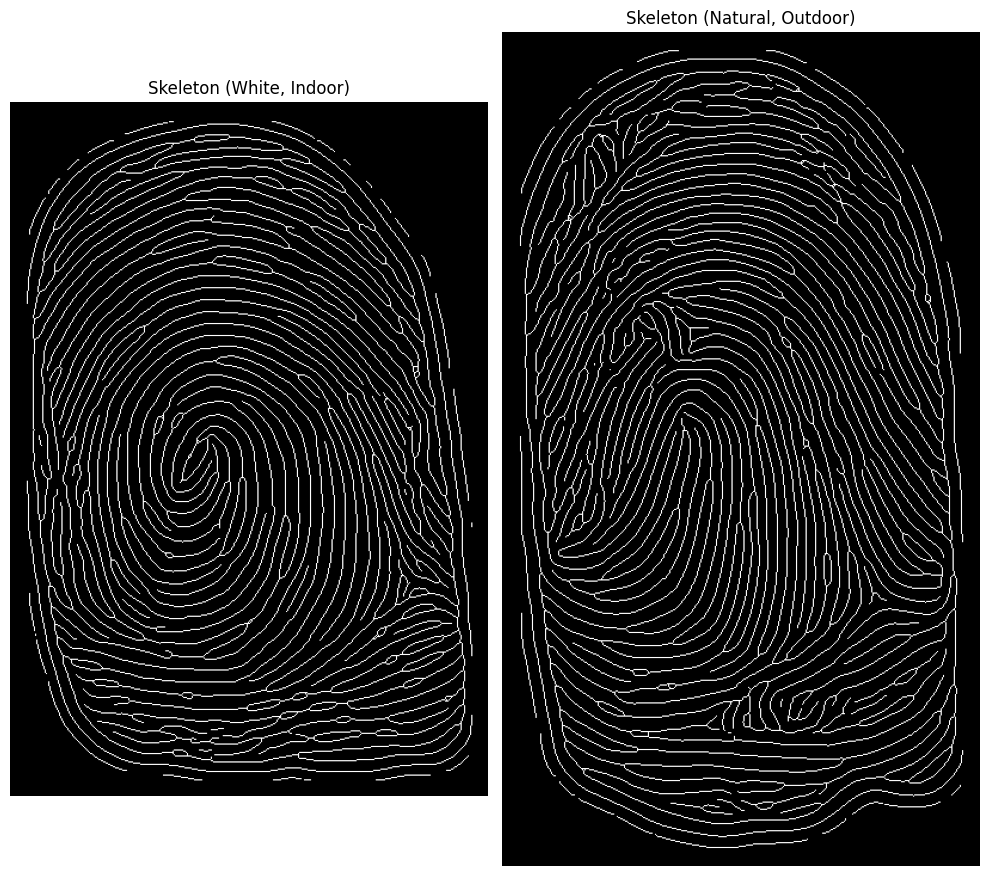

Found 80 keypoints in white indoor fingerprint
Found 80 keypoints in natural outdoor fingerprint


In [7]:
from skimage.morphology import skeletonize
import numpy as np

orb = cv2.ORB_create(nfeatures=80)

skeleton_wi = skeletonize(images[0]).astype(np.uint8) * 255
skeleton_no = skeletonize(images[1]).astype(np.uint8) * 255

mobiofp.plot_images([skeleton_wi, skeleton_no], ['Skeleton (White, Indoor)', 'Skeleton (Natural, Outdoor)'], 1, 2)

# mobiofp.plot_images([skeleton_wi, skeleton_no], ['Skeleton (White, Indoor)', 'Skeleton (Natural, Outdoor)'], 1, 2)

keypoints_wi, descriptor_wi = orb.detectAndCompute(skeleton_wi, None)
keypoints_no, descriptor_no = orb.detectAndCompute(skeleton_no, None)

print(f"Found {len(keypoints_wi)} keypoints in white indoor fingerprint")
print(f"Found {len(keypoints_no)} keypoints in natural outdoor fingerprint")

In [8]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = sorted(bf.match(descriptor_wi, descriptor_no), key=lambda match: match.distance)

print(f"Found {len(matches)} matches")

Found 34 matches


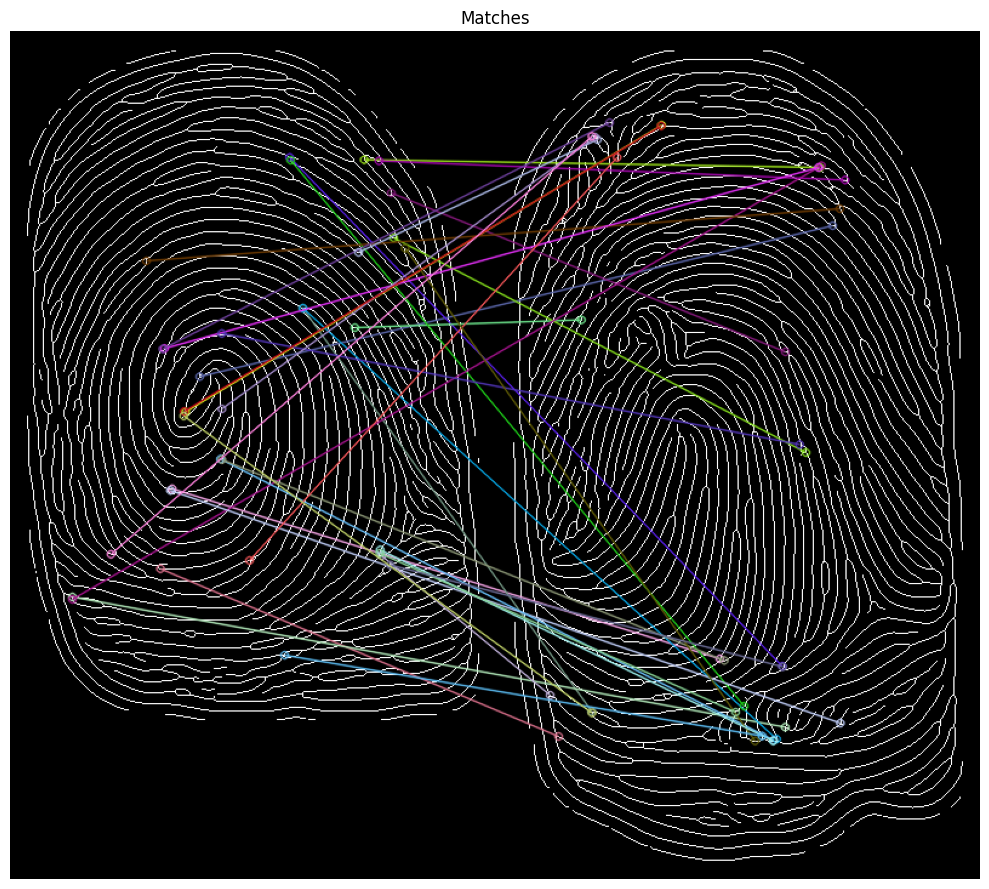

In [9]:
final_img = cv2.drawMatches(skeleton_wi, keypoints_wi, skeleton_no, keypoints_no, matches[:80], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
# final_img = cv2.drawMatches(skeleton_wi, keypoints_wi, skeleton_no, keypoints_no, matches[:80], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

mobiofp.plot_images([final_img], ['Matches'], 1, 1)